# Visium Experiment QC Report

In [1]:
### INPUT FILES ### ex: lib A1

root = ""
date_run = ""
sample_name = ""

#### SPACERANGER COUNT OUTPUTS
# path to unfiltered count matrix (whole slide)
unfiltered_cnts = f"{root}/{date_run}/{sample_name}/outs/raw_feature_bc_matrix/matrix.mtx"
# path to corresponding barcodes and features
uf_bc = f"{root}/{date_run}/{sample_name}/outs/raw_feature_bc_matrix/barcodes.tsv"
uf_genes = f"{root}/{date_run}/{sample_name}/outs/raw_feature_bc_matrix/features.tsv"

# path to filtered count matrix (under tissue)
filtered_cnts = f"{root}/{date_run}/{sample_name}/outs/filtered_feature_bc_matrix/matrix.mtx"
# path to corresponding barcodes and features
f_bc = f"{root}/{date_run}/{sample_name}/outs/filtered_feature_bc_matrix/barcodes.tsv"

f_genes = f"{root}/{date_run}/{sample_name}/outs/filtered_feature_bc_matrix/features.tsv"

# path to spatial barcoding/~tissue_positions.csv
sp = f"{root}/{date_run}/{sample_name}/outs/spatial/tissue_positions.csv"

# path to image file/~detected_tissue_image.jpg
img = f"{root}/{date_run}/{sample_name}/outs/spatial/detected_tissue_image.jpg"

# path to spaceranger web summary
web= f"{root}/{date_run}/{sample_name}/outs/web_summary.html"

metrics = f"{root}/{date_run}/{sample_name}/outs/metrics_summary.csv"

In [2]:
## Extract metrics from spaceranger output

import re

# Read the HTML file
with open(web, 'r', encoding='utf-8') as file:
    html_content = file.read()

# expression pattern to match the sample ID
pattern = r'"sample":{"id":"(.*?)",'
match = re.search(pattern, html_content)

if match:
    # extract
    sample_id = match.group(1)
#     print(f"```markdown\n## Library: {sample_id}\n```")
# else:
#     print("Sample ID not found in the HTML file.")
    
sample = sample_id

pattern2 = r',\["Transcriptome","(.*?)"\]'
match2 = re.search(pattern2, html_content)
transcript = match2.group(1)

pattern3 = r'"Slide Serial Number","(.*?)"'
match3 = re.search(pattern3, html_content)
slide = match3.group(1)

pattern4 = r',\["Total Genes Detected","(.*?)"\]'
match4 = re.search(pattern4, html_content)
total_genes_detected = match4.group(1)

pattern5 = r',\["Median Genes per Spot","(.*?)"\]'
match5 = re.search(pattern5, html_content)
med_genes = match5.group(1)

pattern6 = r',\["Valid Barcodes","(.*?)"\]'
match6 = re.search(pattern6, html_content)
valid_barcodes = match6.group(1)

pattern7 = r',\["Valid UMIs","(.*?)"\]'
match7 = re.search(pattern7, html_content)
umis = match7.group(1)

pattern8 = r'"Number of Reads","(\d{1,3}(?:,\d{3})*)"'
match8 = re.search(pattern8, html_content)
tot_reads = match8.group(1)

pattern9 = r',\["Mean Reads per Spot","(.*?)"\]'
match9 = re.search(pattern9, html_content)
av_reads_spot_all = match9.group(1)

pattern10 = r',\["Mean Reads Under Tissue per Spot","(.*?)"\]'
match10 = re.search(pattern10, html_content)
av_reads_spot_tissue = match10.group(1)

pattern11 = r'"Fraction Reads in Spots Under Tissue","(\d+\.\d+%)'
match11 = re.search(pattern11, html_content)
fraction_reads_tissue = match11.group(1)

pattern12 = r'"Reads Mapped to Genome","(\d+\.\d+%)'
match12 = re.search(pattern12, html_content)
reads_mapped = match12.group(1)

pattern13 = r',\["Reads Mapped Confidently to Genome","(.*?)"\]'
match13 = re.search(pattern13, html_content)
reads_confidently_mapped = match13.group(1)

pattern14 = r',\["Reads Mapped Confidently to Intronic Regions","(.*?)"\]'
match14 = re.search(pattern14, html_content)
reads_confidently_mapped_introns = match14.group(1)

pattern15 = r',\["Reads Mapped Confidently to Transcriptome","(.*?)"\]'
match15 = re.search(pattern15, html_content)
reads_confidently_mapped_transcriptome = match15.group(1)

In [3]:
from IPython.display import Markdown as md
md (f"# Library: {sample_id}")

# Library: V11M22-394_JGCRC28T_C1

## Metrics from spaceranger count output

In [4]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(metrics)
df.set_index('Sample ID', inplace=True)
df = df.round(4)
df = df.style.format({'Fraction Reads in Spots Under Tissue': '{:.2%}', 'Reads Mapped Antisense to Gene': '{:.2%}',
                      'Reads Mapped Confidently to Transcriptome': '{:.2%}','Reads Mapped Confidently to Exonic Regions': '{:.2%}','Reads Mapped Antisense to Gene': '{:.2%}',
                      'Reads Mapped Confidently to Intronic Regions': '{:.2%}','Reads Mapped Confidently to Intergenic Regions': '{:.2%}',
                      'Reads Mapped Confidently to Genome': '{:.2%}','Reads Mapped to Genome': '{:.2%}',
                      'Q30 Bases in UMI': '{:.2%}','Q30 Bases in RNA Read': '{:.2%}',
                      'Q30 Bases in Barcode': '{:.2%}','Sequencing Saturation': '{:.2%}',
                      'Valid UMIs': '{:.2%}','Valid Barcodes': '{:.2%}','Fraction of Spots Under Tissue': '{:.2%}',
                      'Mean Reads per Spot':'{:.2f}','Mean Reads Under Tissue per Spot':'{:.2f}','Median Genes per Spot':'{:.2f}', 
                      'Median UMI Counts per Spot':'{:.2f}'})
df

/scratch/ipykernel_46655/233604941.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Inside vs. Outside Tissue

In [5]:
### define dataframe for outside tissue data

import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread
import numpy as np

uf_matrix = mmread(unfiltered_cnts)
uf_matrix_array = np.array(uf_matrix.toarray())
uf_spot_gene = pd.DataFrame(uf_matrix_array)
uf_col = pd.read_csv(uf_bc,sep='\t', header=None).values
uf_col = uf_col.flatten()
uf_spot_gene.columns = uf_col

coords = pd.read_csv(sp)

outside_tissue = coords[coords["in_tissue"] == 0]
outside_spots_indexes = outside_tissue["barcode"]
#outside_spots = uf_spot_gene[outside_spots_indexes] yields error if not perfect match
outside_spots = uf_spot_gene[uf_spot_gene.columns[uf_spot_gene.columns.isin(outside_spots_indexes)]]
outside_counts_per_spot = np.sum(outside_spots, axis=0)
outside_genes_per_spot = np.sum(outside_spots > 0, axis=0)

In [6]:
## Determine max value for spatial heatmap colorscale-UNFILTERED

import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread
import numpy as np

f_matrix = mmread(filtered_cnts)
f_matrix_array = np.array(f_matrix.toarray())
f_spot_gene = pd.DataFrame(f_matrix_array)
f_col = pd.read_csv(f_bc,sep='\t', header=None).values
f_col = f_col.flatten()
f_spot_gene.columns = f_col

# Calculate total counts per barcode
f_total_counts_per_spot = f_spot_gene.sum(axis=0)

# Sort barcodes based on total counts
f_sorted_barcodes = f_total_counts_per_spot.sort_values(ascending=False)

f_percentile_95 = np.percentile(f_total_counts_per_spot, 95)

### genes 

### genes 
f_genes_per_spot = np.sum(f_matrix_array > 0, axis=0)
f_genes_percentile_95 = np.percentile(f_genes_per_spot, 95)


In [7]:
## Determine max value for spatial heatmap colorscale-FILTERED

uf_matrix = mmread(unfiltered_cnts)
uf_matrix_array = np.array(uf_matrix.toarray())
uf_spot_gene = pd.DataFrame(uf_matrix_array)
uf_col = pd.read_csv(uf_bc,sep='\t', header=None).values
uf_col = uf_col.flatten()
uf_spot_gene.columns = uf_col

# Calculate total counts per barcode
uf_total_counts_per_spot = uf_spot_gene.sum(axis=0)

outside_counts_per_spot = np.sum(outside_spots, axis=0)

# Sort barcodes based on total counts
uf_sorted_barcodes = uf_total_counts_per_spot.sort_values(ascending=False)
uf_percentile_95 = np.percentile(uf_total_counts_per_spot, 95)

sorted_outside_counts_per_spot = outside_counts_per_spot.sort_values(ascending=False)
outside_counts_per_spot_p95 = np.percentile(outside_counts_per_spot, 95)

### genes 
uf_genes_per_spot = np.sum(uf_matrix_array > 0, axis=0)
uf_genes_percentile_95 = np.percentile(uf_genes_per_spot, 95)

outside_genes_per_spot = np.sum(outside_spots > 0, axis=0)
outside_genes_per_spot_p95 = np.percentile(outside_genes_per_spot, 95)



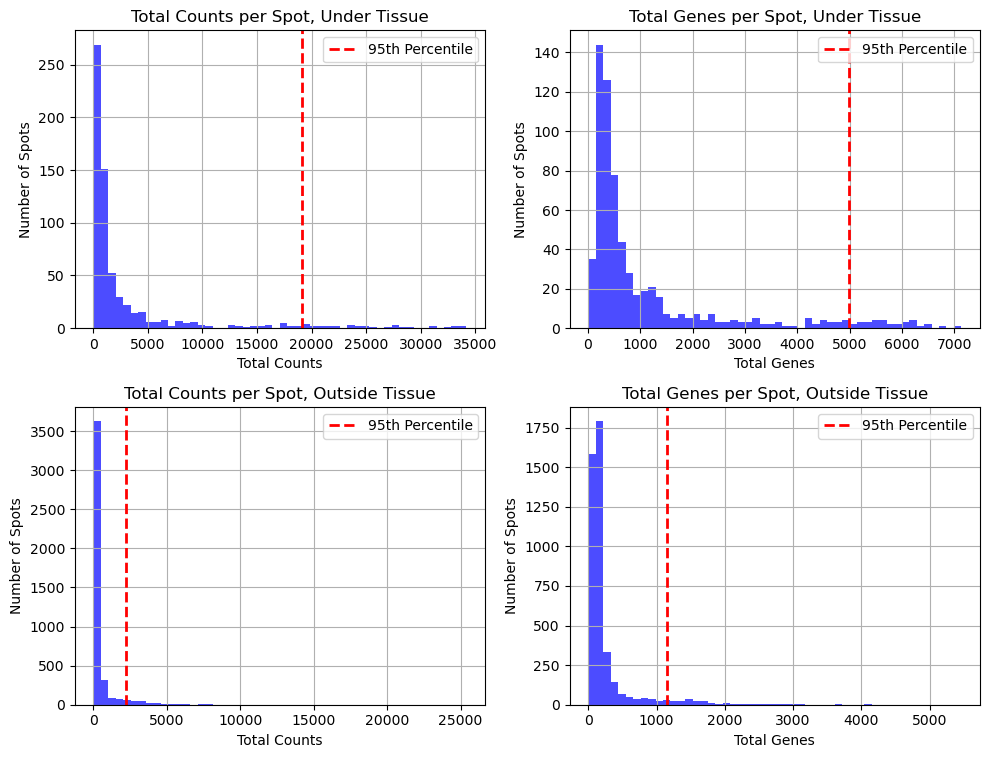

In [8]:
# Plot histograms in a 2x2 grid for counts + genes

import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread
import numpy as np

def plot_histogram(ax, data, title, xlabel, ylabel, percentile_line_color='red'):
    # Plot histogram
    ax.hist(data, bins=50, color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axvline(x=np.percentile(data, 95), color=percentile_line_color, linestyle='dashed', linewidth=2, label='95th Percentile')
    ax.legend()
    ax.grid(True)

# Read filtered data
f_matrix = mmread(filtered_cnts)
f_matrix_array = np.array(f_matrix.toarray())
f_spot_gene = pd.DataFrame(f_matrix_array)
f_col = pd.read_csv(f_bc, sep='\t', header=None).values.flatten()
f_spot_gene.columns = f_col

# Plot histograms in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot 1
plot_histogram(axes[0, 0], f_total_counts_per_spot, 'Total Counts per Spot, Under Tissue', 'Total Counts', 'Number of Spots')

# Plot 2
plot_histogram(axes[0, 1], f_genes_per_spot, 'Total Genes per Spot, Under Tissue', 'Total Genes', 'Number of Spots')

# Read unfiltered data
uf_matrix = mmread(unfiltered_cnts)
uf_matrix_array = np.array(uf_matrix.toarray())
uf_spot_gene = pd.DataFrame(uf_matrix_array)
uf_col = pd.read_csv(uf_bc, sep='\t', header=None).values.flatten()
uf_spot_gene.columns = uf_col

# Plot 3
plot_histogram(axes[1, 0], outside_counts_per_spot, 'Total Counts per Spot, Outside Tissue', 'Total Counts', 'Number of Spots')

# Plot 4
plot_histogram(axes[1, 1], outside_genes_per_spot, 'Total Genes per Spot, Outside Tissue', 'Total Genes', 'Number of Spots')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

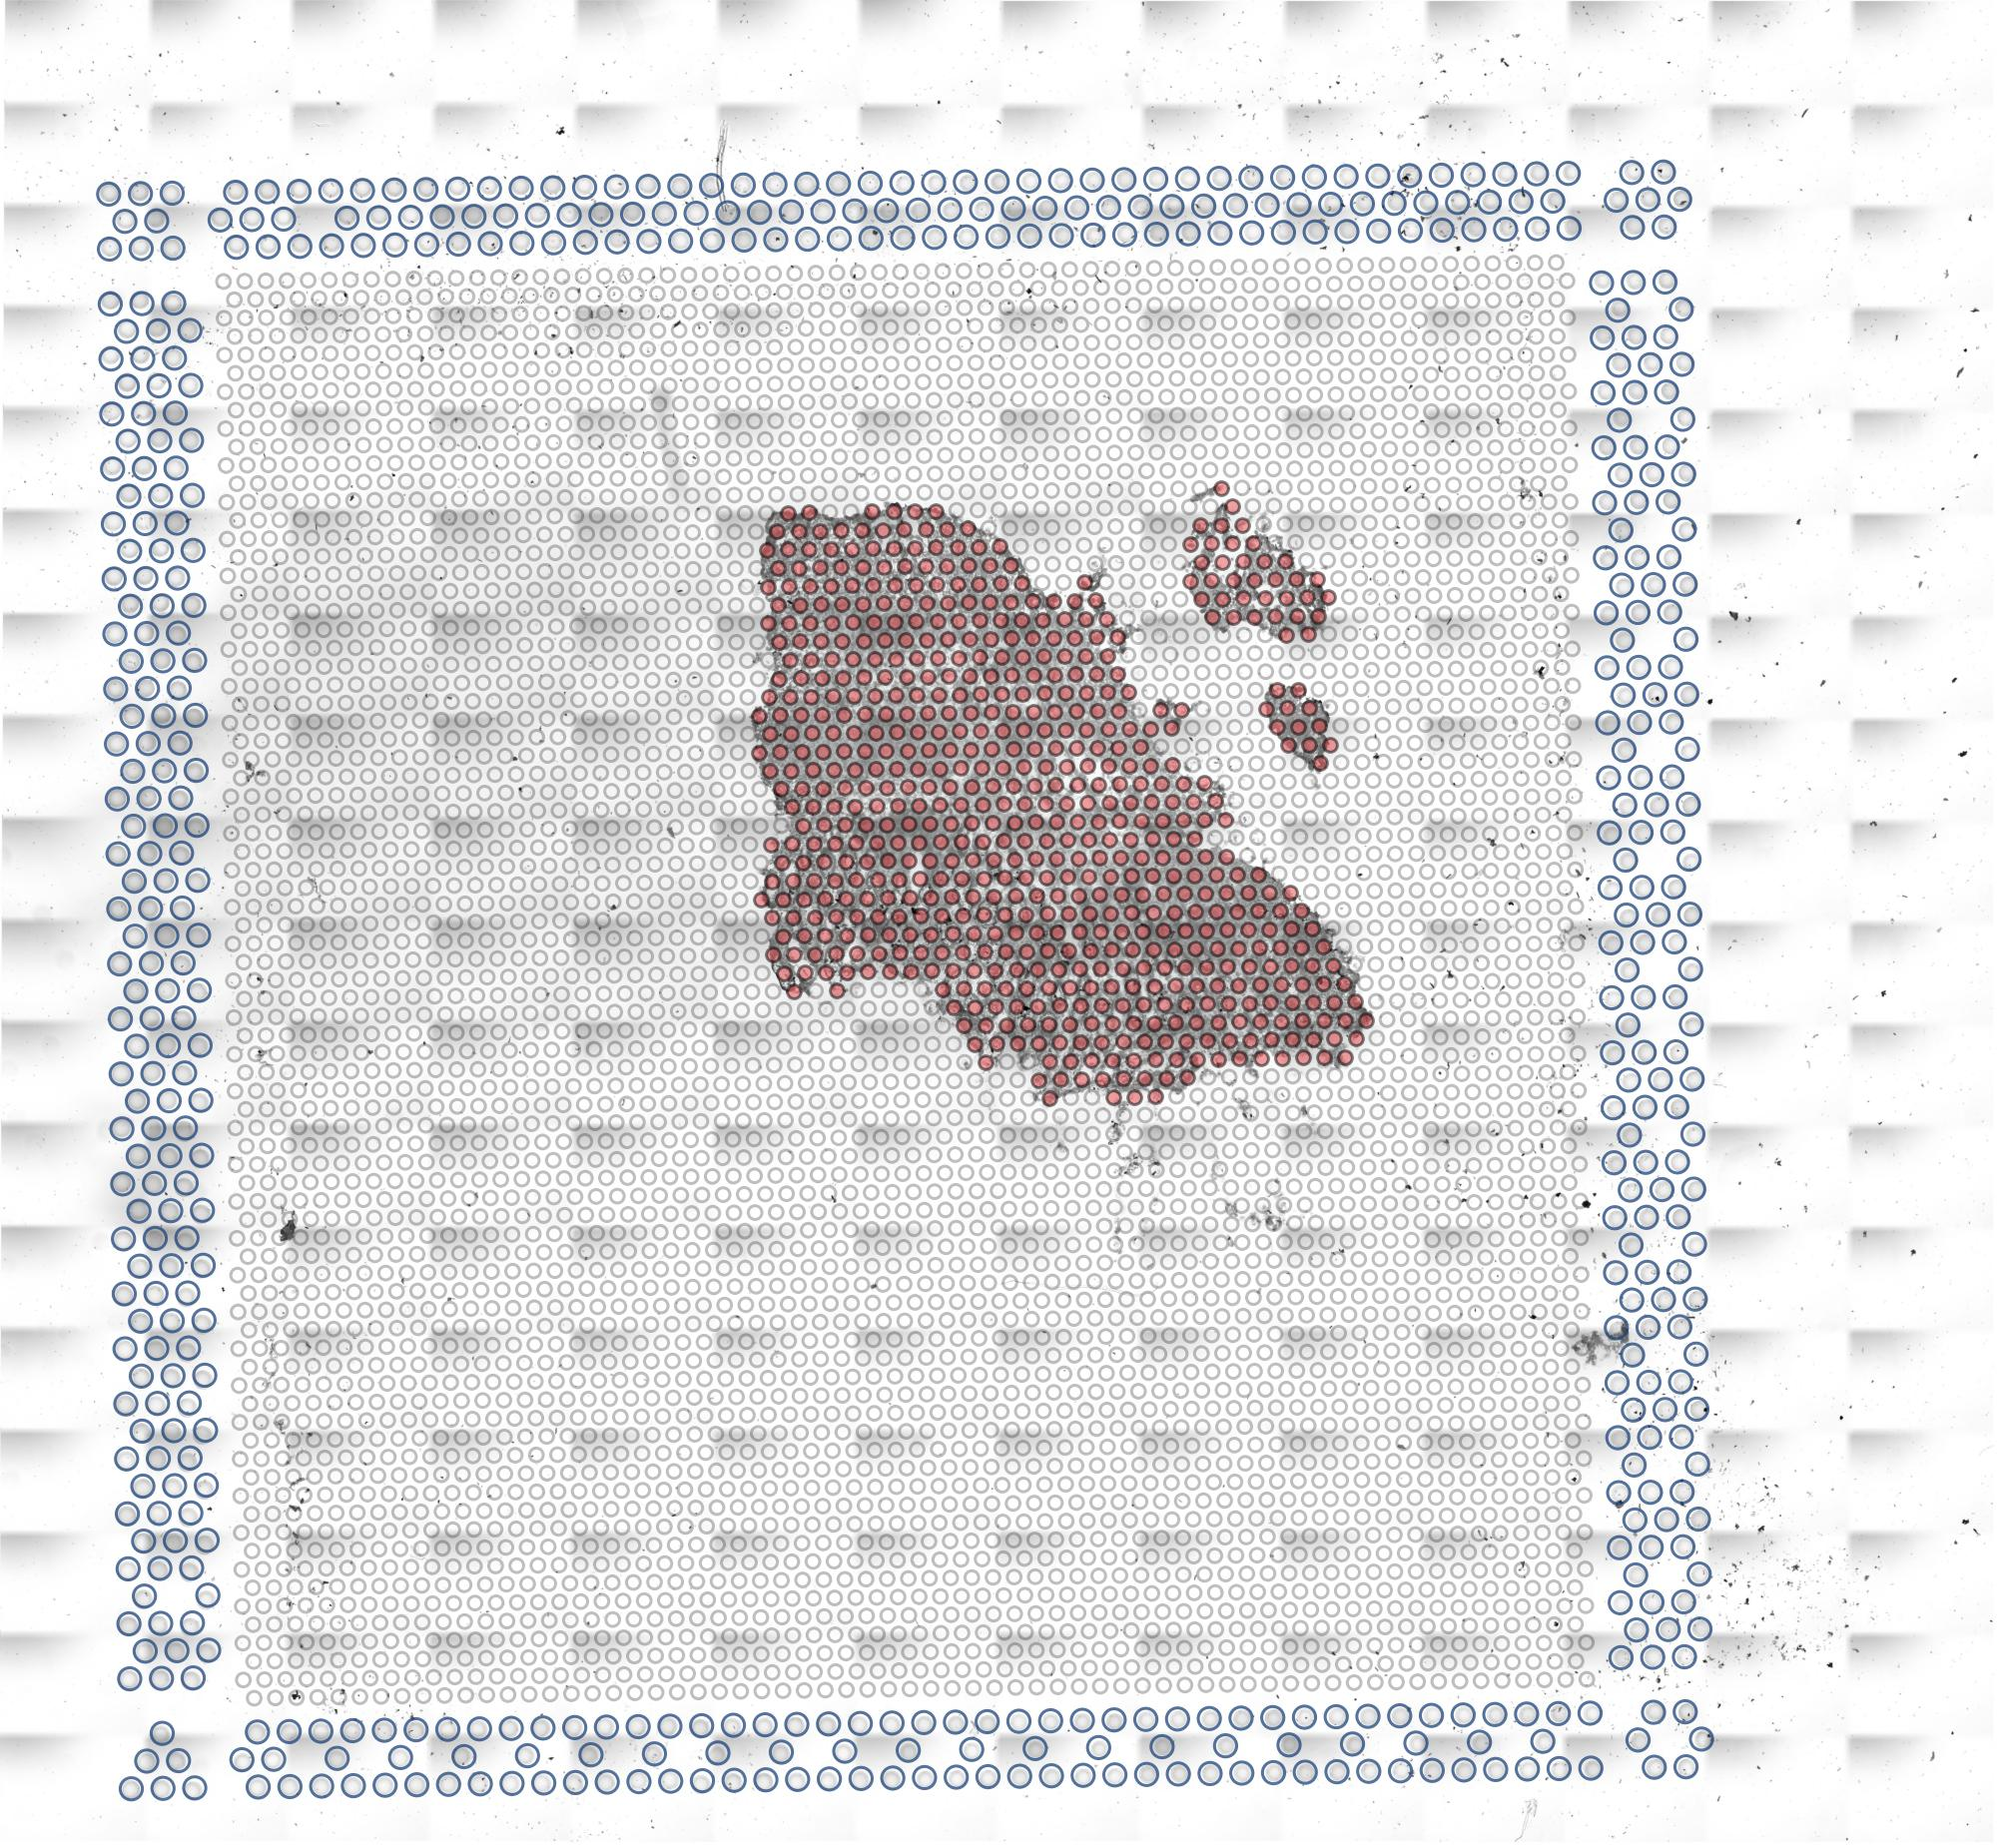

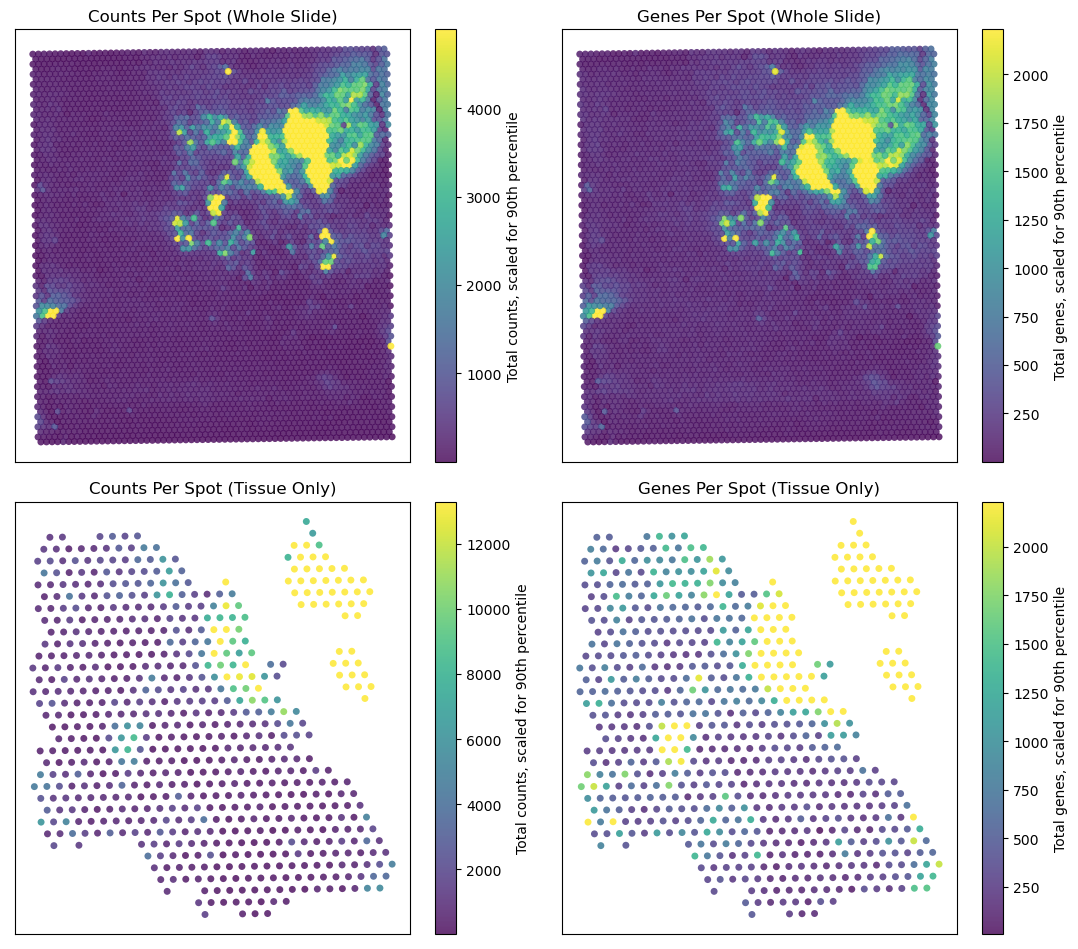

In [9]:
from IPython.display import display, Image
import matplotlib.pyplot as plt

# Display image
display(Image(filename=img, width=500))

## WHOLE SLIDE

import gzip
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt

uf_matrix = mmread(unfiltered_cnts)
uf_matrix_array = np.array(uf_matrix.toarray())
uf_spot_gene = pd.DataFrame(uf_matrix_array)
uf_col = pd.read_csv(uf_bc,sep='\t', header=None).values
uf_col = uf_col.flatten()
uf_spot_gene.columns = uf_col

# Coordinates
coords = pd.read_csv(sp)
coord_cols = uf_spot_gene.columns
x = []
y = []
for c in coord_cols:
    result = coords[coords['barcode'] == c]
    x.append(result['pxl_row_in_fullres'].values[0])
    y.append(result['pxl_col_in_fullres'].values[0])

counts_per_spot = np.sum(uf_matrix_array, axis=0)
genes_per_spot = np.sum(uf_matrix_array > 0, axis=0)

x = np.array(x)
y = np.array(y)

uf_subset_90 = counts_per_spot[counts_per_spot < np.quantile(counts_per_spot, 0.95)]
uf_subset_90_max = uf_subset_90.max()
uf_subset_90_max = uf_subset_90_max + 0.5*(uf_subset_90_max)

uf_genesubset_90 = genes_per_spot[genes_per_spot < np.quantile(genes_per_spot, 0.95)]
uf_genesubset_90_max = uf_genesubset_90.max()
uf_genesubset_90_max = uf_genesubset_90_max + 0.5*(uf_genesubset_90_max)

# TISSUE ONLY

f_matrix = mmread(filtered_cnts)
f_matrix_array = np.array(f_matrix.toarray())
f_spot_gene = pd.DataFrame(f_matrix_array)
f_col = pd.read_csv(f_bc,sep='\t', header=None).values
f_col = f_col.flatten()
f_spot_gene.columns = f_col

# Coordinates
coords = pd.read_csv(sp)
f_coord_cols = f_spot_gene.columns
z = []
w = []
e = 0.0000000000000000001
for d in f_coord_cols:
    result = coords[coords['barcode'] == d]
    z.append(result['pxl_row_in_fullres'].values[0])
    w.append(result['pxl_col_in_fullres'].values[0])

f_counts_per_spot = np.sum(f_matrix_array, axis=0)
f_genes_per_spot = np.sum(f_matrix_array > 0, axis=0)

f_subset_90 = f_total_counts_per_spot[f_total_counts_per_spot < np.quantile(f_total_counts_per_spot, 0.9)]
f_subset_90_max = f_subset_90.max()
f_subset_90_max = f_subset_90_max + 0.5*f_subset_90_max

f_genesubset_90 = genes_per_spot[genes_per_spot < np.quantile(genes_per_spot, 0.95)]
f_genesubset_90_max = f_genesubset_90.max()
f_genesubset_90_max = f_genesubset_90_max + 0.5*(f_genesubset_90_max)

z = np.array(z)
w = np.array(w)

# Create subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 10))

# Plot for Whole Slide - Counts per Spot
sc1 = axes[0, 0].scatter(y / 2, x, c=counts_per_spot, cmap='viridis', alpha=0.8, s=25, edgecolors='none', vmax=uf_subset_90_max)
axes[0, 0].set_title('Counts Per Spot (Whole Slide)')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].invert_yaxis()
cbar1 = fig.colorbar(sc1, ax=axes[0, 0], orientation='vertical',label='Total counts, scaled for 90th percentile')

# Plot for Whole Slide - Genes per Spot
sc2 = axes[0, 1].scatter(y / 2, x, c=genes_per_spot, cmap='viridis', alpha=0.8, s=25, edgecolors='none', vmax=uf_genesubset_90_max)
axes[0, 1].set_title('Genes Per Spot (Whole Slide)')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].invert_yaxis()
cbar2 = fig.colorbar(sc2, ax=axes[0, 1], orientation='vertical',label='Total genes, scaled for 90th percentile')

# Plot for Tissue Only - Counts per Spot
sc3 = axes[1, 0].scatter(w / 2, z, c=f_counts_per_spot, cmap='viridis', alpha=0.8, s=25, edgecolors='none', vmax=f_subset_90_max)
axes[1, 0].set_title('Counts Per Spot (Tissue Only)')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].invert_yaxis()
cbar3 = fig.colorbar(sc3, ax=axes[1, 0], orientation='vertical',label='Total counts, scaled for 90th percentile')

# Plot for Tissue Only - Genes per Spot
sc4 = axes[1, 1].scatter(w / 2, z, c=f_genes_per_spot, cmap='viridis', alpha=0.8, s=25, edgecolors='none', vmax=f_genesubset_90_max)
axes[1, 1].set_title('Genes Per Spot (Tissue Only)')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].invert_yaxis()
cbar4 = fig.colorbar(sc4, ax=axes[1, 1], orientation='vertical',label='Total genes, scaled for 90th percentile')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [10]:
outside_tissue = coords[coords["in_tissue"] == 0]
outside_spots_indexes = outside_tissue["barcode"]
#outside_spots = uf_spot_gene[outside_spots_indexes] yields error if not perfect match
outside_spots = uf_spot_gene[uf_spot_gene.columns[uf_spot_gene.columns.isin(outside_spots_indexes)]]
outside_counts_per_spot = np.sum(outside_spots, axis=0)
outside_genes_per_spot = np.sum(outside_spots > 0, axis=0)

In [11]:
#### Counts inside vs. outside tissue

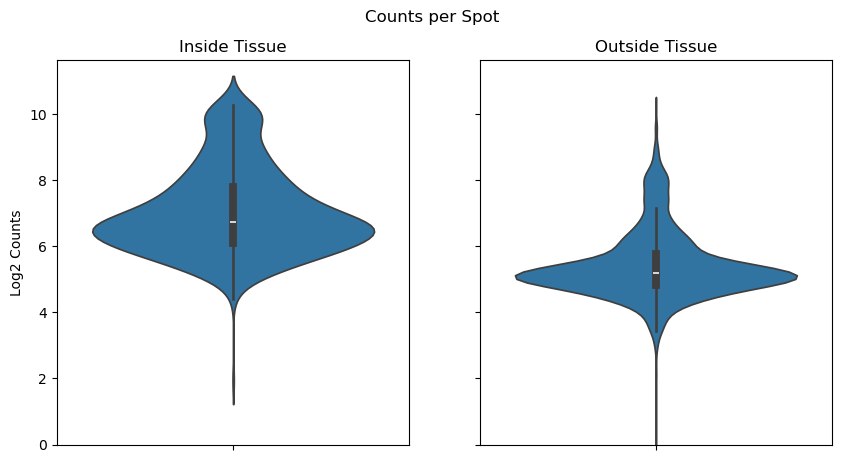

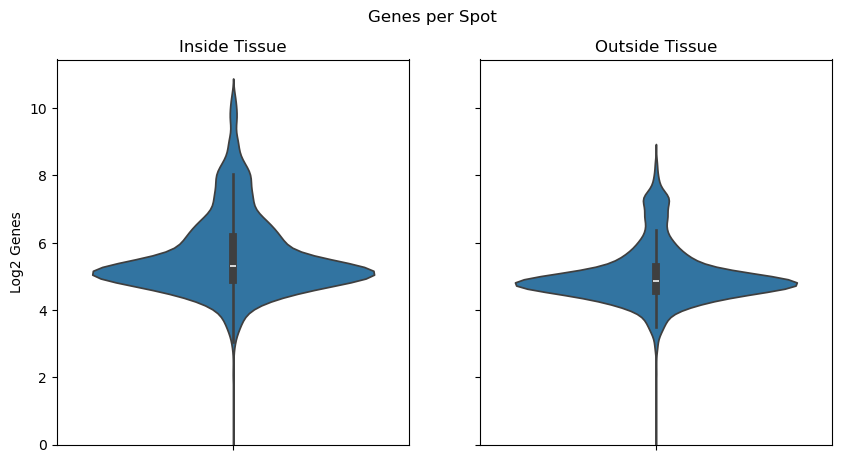

In [12]:
# VIOLIN PLOTS 
import seaborn as sns

e=0.000000000000001
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.violinplot(data=np.log(f_counts_per_spot+e), ax=ax1)
ax1.set_title("Inside Tissue")
ax1.set_ylabel('Log2 Counts') 
ax1.set_ylim(bottom=0)
sns.violinplot(data=np.log(outside_counts_per_spot+e), ax=ax2)
ax2.set_title("Outside Tissue")
ax2.set_ylim(bottom=0)
fig.suptitle('Counts per Spot')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.violinplot(data=np.log(counts_per_spot+e), ax=ax1)
ax1.set_title("Inside Tissue")
ax1.set_ylabel('Log2 Genes') 
ax1.set_ylim(bottom=0)
sns.violinplot(data=np.log(outside_genes_per_spot+e), ax=ax2)
ax2.set_title("Outside Tissue")
ax2.set_ylim(bottom=0)
fig.suptitle('Genes per Spot')
plt.show()

## Visualization of gene density: number of transcripts, number of spots per gene

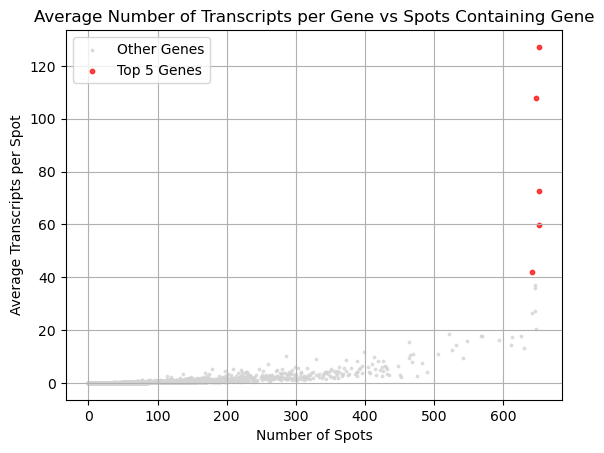

In [13]:
### scatterplot showing where the top 5 expressed genes fall 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the number of samples containing each gene
samples_containing_gene = (f_spot_gene > 0).sum(axis=1)

# Calculate the av counts for each gene
av_counts_per_gene = f_spot_gene.mean(axis=1)


all_gene_names = pd.read_csv(f_genes, sep='\t', header=None)[1]
f_spot_gene.index = all_gene_names

# Determine the top 5 expressed genes
indices = f_matrix_array.sum(axis=1).argsort()[-5:]
top_5_genes = pd.read_csv(f_genes, sep='\t', header=None)[1][indices]
# Create a mask for the top 5 genes
top_5_mask = f_spot_gene.index.isin(top_5_genes)

# Create a scatter plot
plt.scatter(samples_containing_gene[~top_5_mask], av_counts_per_gene[~top_5_mask], color = 'lightgrey',alpha=0.7, s=3, label='Other Genes')
plt.scatter(samples_containing_gene[top_5_mask], av_counts_per_gene[top_5_mask], color='red', alpha=0.7, s=10, label='Top 5 Genes')
plt.xlabel('Number of Spots')
plt.ylabel('Average Transcripts per Spot')
plt.title('Average Number of Transcripts per Gene vs Spots Containing Gene')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
## top 5 genes sanity check
all_gene_names = pd.read_csv(f_genes, sep='\t', header=None)[1]
f_spot_gene.index = all_gene_names

# Determine the top 5 expressed genes
indices = f_matrix_array.sum(axis=1).argsort()[-5:]
top_5_genes = pd.read_csv(f_genes, sep='\t', header=None)[1][indices]

## Spatial distribution of top 5 expressed genes

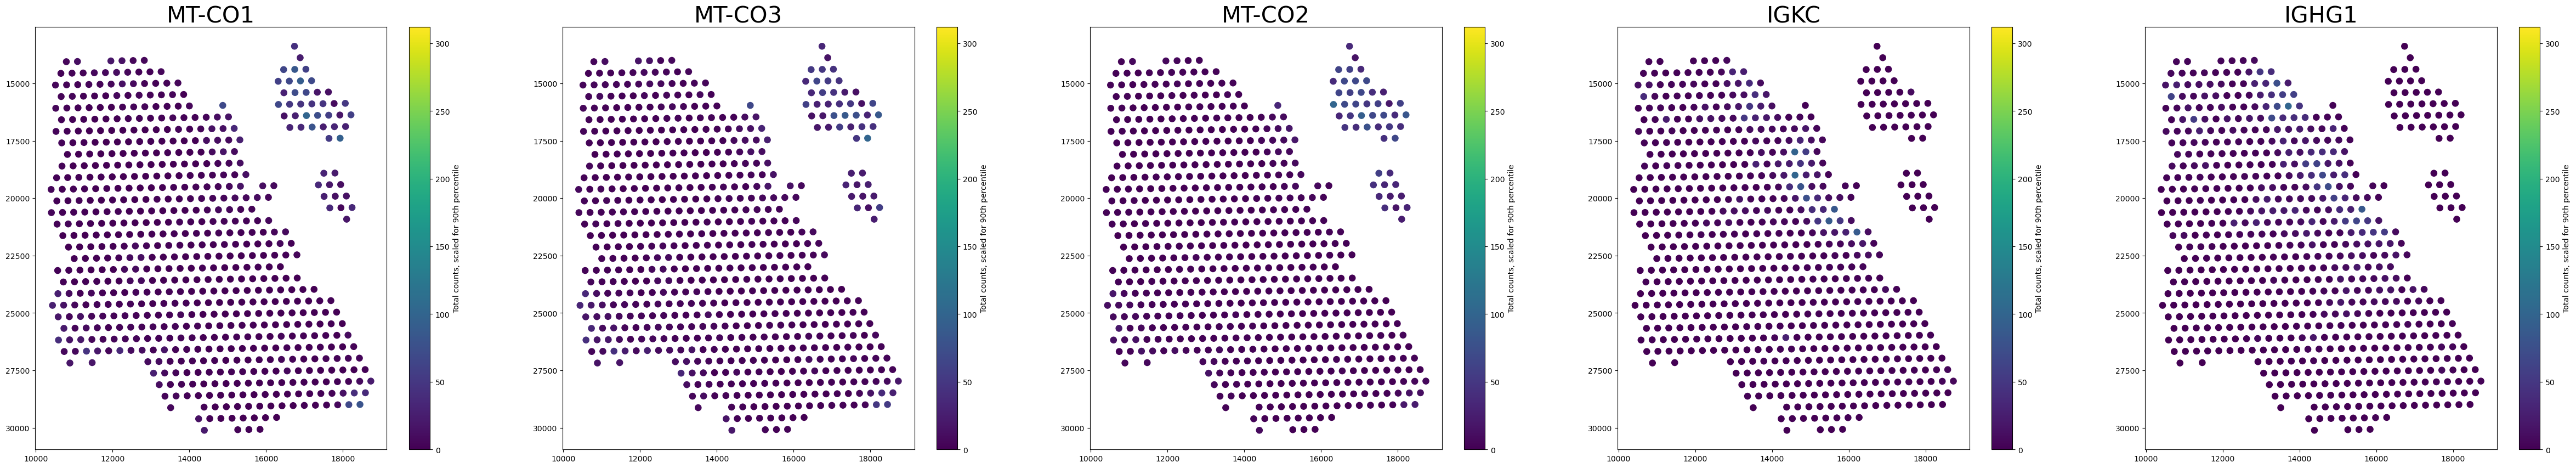

In [15]:
## Plot spatial heatmap of top 5 expressed genes

indices = f_matrix_array.sum(axis=1).argsort()[-5:]

f_matrix_array.sum(axis=1)[indices]

top_5_95 = f_matrix_array[indices][f_matrix_array[indices] < np.quantile(f_matrix_array[indices], 0.90)]
top_5_95_max = top_5_95.max()
top_5_95_max = top_5_95_max + 0.5*(top_5_95_max)

gene_names = pd.read_csv(f_genes, sep='\t', header=None)[1][indices]

fig, ax = plt.subplots(1, 5, figsize = (60,10))
e = 0.0000000000001
for i in range(5):
    sc = ax[i].scatter(w / 2, z, c = (f_matrix_array[indices[i],:] / max(f_matrix_array[indices[i],:])) * 100, s = 65,vmax=top_5_95_max)
    ax[i].invert_yaxis()
    ax[i].set_title(gene_names[indices[i]], fontsize=30)
    fig.colorbar(sc, ax=ax[i],label='Total counts, scaled for 90th percentile') # Add color bar with label


In [16]:
### Cell types
counts_matrix = f_spot_gene
counts_matrix.index = all_gene_names
counts_matrix.index.name = None
#
limpho_markers = ['CD3E',"CD3D","CD4","CD8A","CD8B","IL7R","TCF7"]
limpho_subset = counts_matrix[counts_matrix.index.isin(limpho_markers)]
#
colon_diff_markers = ['KRT20','TSPAN1','CEACAM5']
colon_diff_subset = counts_matrix[counts_matrix.index.isin(colon_diff_markers)]
#
goblet_sec_markers = ['MUC1', 'ZG16', 'ATOH1', 'FCGBP', 'TFF3', 'SERPINA1', 'SPINK4', 'SPINK1']
goblet_sec_subset = counts_matrix[counts_matrix.index.isin(goblet_sec_markers)]
#
entero_markers = ['BEST4', 'OTOP2', 'FABP1', 'CA2', 'SLC26A3', 'CA1', 'SLC26A2']
entero_subset = counts_matrix[counts_matrix.index.isin(entero_markers)]
#
isc_markers = ['ADH1C', 'LEFTY1', 'OLFM4', 'RARRES2', 'LGR5', 'ASCL2', 'SMOC2', 'MEX3A']
isc_subset = counts_matrix[counts_matrix.index.isin(isc_markers)]
#
neuroendocrine_markers = ['NEUROD1', 'CHGA', 'SCGN']
neuroendocrine_subset = counts_matrix[counts_matrix.index.isin(neuroendocrine_markers)]
# 
tuft_markers = ['TRPM5', 'LRMP', 'SH2D6']
tuft_subset = counts_matrix[counts_matrix.index.isin(tuft_markers)]
# 
proliferative_markers = ['MKI67']
proliferative_subset = counts_matrix[counts_matrix.index.isin(proliferative_markers)]
# CD8PosT genes
cd8post_genes = ['TOX', 'LAG3', 'TIGIT', 'IFNG', 'GZMB', 'GZMH']
cd8post_subset = counts_matrix[counts_matrix.index.isin(cd8post_genes)]
# CD4PosT genes
cd4post_genes = ['IL17A', 'CTL4A', 'SOX4']
cd4post_subset = counts_matrix[counts_matrix.index.isin(cd4post_genes)]
# GDlikeT genes
gdlike_genes = ['TRGC1', 'TRGC2']
gdlike_subset = counts_matrix[counts_matrix.index.isin(gdlike_genes)]
# Bcells genes
bcells_genes = ['CD79A', 'CD74', 'CD19', 'MS4A1', 'TCL1A', 'IGHD', 'IGHM']
bcells_subset = counts_matrix[counts_matrix.index.isin(bcells_genes)]
# PlasmaCells genes
plasma_cells_genes = ['IGHA1', 'JCHAIN', 'MZB1', 'IGHG1', 'IGHG3', 'IGHG4']
plasma_cells_subset = counts_matrix[counts_matrix.index.isin(plasma_cells_genes)]
# Mast genes
mast_genes = ['TPSAB1', 'CPA3', 'KIT']
mast_subset = counts_matrix[counts_matrix.index.isin(mast_genes)]
# Mono genes
mono_genes = ['FCN1']
mono_subset = counts_matrix[counts_matrix.index.isin(mono_genes)]
# Macro genes
macro_genes = ['VCAN', 'CD300E', 'S100A12', 'CD163', 'APOC1', 'LIPA', 'C1QA', 'CSF1R']
macro_subset = counts_matrix[counts_matrix.index.isin(macro_genes)]
# DCs genes
dcs_genes = ['CLEC9A', 'CLEC10A', 'CLEC4C']
dcs_subset = counts_matrix[counts_matrix.index.isin(dcs_genes)]
# Granulo genes
granulo_genes = ['FCGR3B', 'HCAR2', 'GPR109B', 'CSF3R']
granulo_subset = counts_matrix[counts_matrix.index.isin(granulo_genes)]
# Fibrostroma genes
fibrostroma_genes = ['ACTA2', 'LUM', 'TAGLN', 'VIM', 'COL3A1', 'COL6A2', 'COL1A2', 'FN1', 'CD81', 'MYH9']
fibrostroma_subset = counts_matrix[counts_matrix.index.isin(fibrostroma_genes)]
# Panepithelial genes
panepithelial_genes = ['CDH1', 'EPCAM', 'KRT8', 'KRT18', 'EZR']
panepithelial_subset = counts_matrix[counts_matrix.index.isin(panepithelial_genes)]

In [17]:
# Create a mask for the limpho genes
limpho_mask = counts_matrix.index.isin(limpho_markers)
colon_diff_mask = counts_matrix.index.isin(colon_diff_markers)
goblet_sec_mask = counts_matrix.index.isin(goblet_sec_markers)
entero_mask = counts_matrix.index.isin(entero_markers)
isc_mask = counts_matrix.index.isin(isc_markers)
neuroendocrine_mask = counts_matrix.index.isin(neuroendocrine_markers)
tuft_mask = counts_matrix.index.isin(tuft_markers)
proliferative_mask = counts_matrix.index.isin(proliferative_markers)
cd8post_mask = counts_matrix.index.isin(cd8post_genes)
cd4post_mask = counts_matrix.index.isin(cd4post_genes)
gdlike_mask = counts_matrix.index.isin(gdlike_genes)
bcells_mask = counts_matrix.index.isin(bcells_genes)
plasma_cells_mask = counts_matrix.index.isin(plasma_cells_genes)
mast_mask = counts_matrix.index.isin(mast_genes)
mono_mask = counts_matrix.index.isin(mono_genes)
macro_mask = counts_matrix.index.isin(macro_genes)
dcs_mask = counts_matrix.index.isin(dcs_genes)
granulo_mask = counts_matrix.index.isin(granulo_genes)
fibrostroma_mask = counts_matrix.index.isin(fibrostroma_genes)
panepithelial_mask = counts_matrix.index.isin(panepithelial_genes)

## Cell type-specific average expression per spot

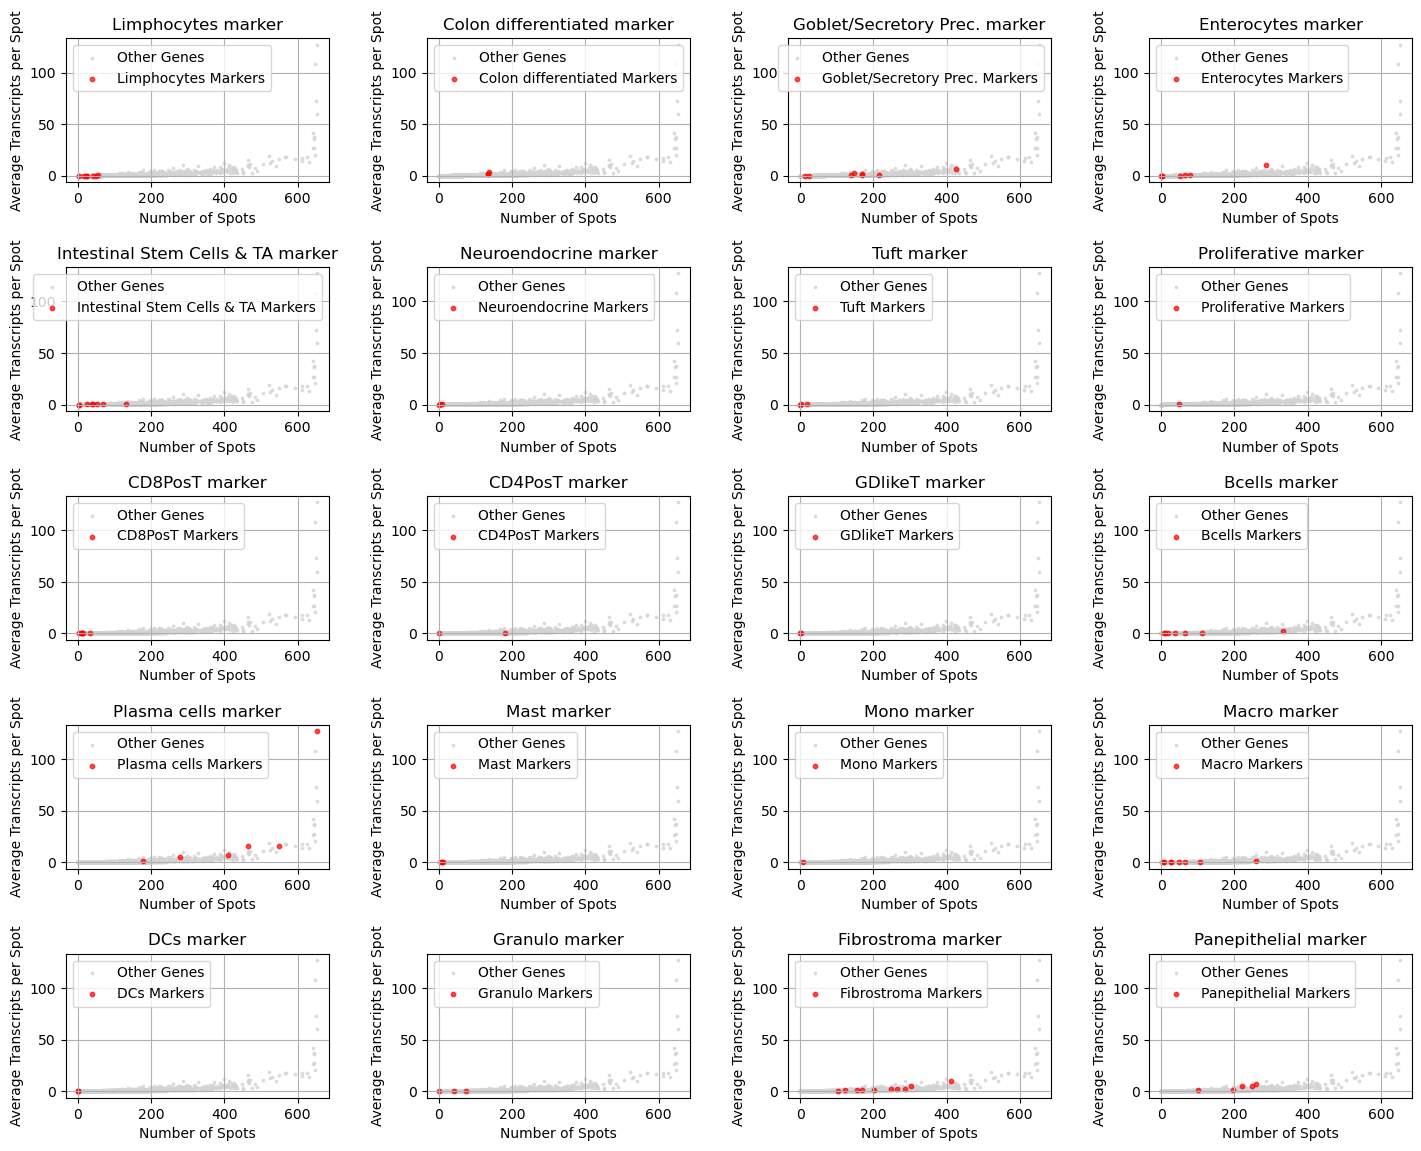

In [18]:
import matplotlib.pyplot as plt

# Create a 5x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 12))
fig.tight_layout(pad=4.0)

# Create masks and marker types (as previously shown)

# List of masks and corresponding marker types
masks = [limpho_mask, colon_diff_mask, goblet_sec_mask, entero_mask, isc_mask, neuroendocrine_mask, tuft_mask,
         proliferative_mask, cd8post_mask, cd4post_mask, gdlike_mask, bcells_mask, plasma_cells_mask, mast_mask,
         mono_mask, macro_mask, dcs_mask, granulo_mask, fibrostroma_mask, panepithelial_mask]

cell_types = ['Limphocytes','Colon differentiated', 'Goblet/Secretory Prec.', 'Enterocytes', 'Intestinal Stem Cells & TA', 'Neuroendocrine', 'Tuft', 'Proliferative', 'CD8PosT', 'CD4PosT', 'GDlikeT', 'Bcells', 'Plasma cells', 'Mast', 'Mono', 'Macro', 'DCs', 'Granulo', 'Fibrostroma', 'Panepithelial']

# Iterate over masks and corresponding colors
for i, (mask, cell) in enumerate(zip(masks, cell_types)):
    row = i // 4
    col = i % 4

    # Scatter plot for each marker type
    axes[row, col].scatter(samples_containing_gene[~mask], av_counts_per_gene[~mask], color='lightgrey', alpha=0.7, s=3, label='Other Genes')
    axes[row, col].scatter(samples_containing_gene[mask], av_counts_per_gene[mask], color='red', alpha=0.7, s=10, label=f'{cell} Markers')
    axes[row, col].set_xlabel('Number of Spots')
    axes[row, col].set_ylabel('Average Transcripts per Spot')
    axes[row, col].set_title(f'{cell} marker')
    axes[row, col].legend()
    axes[row, col].grid(True)

# Show the plot
plt.show()

## Cell type-specific total expression per spot

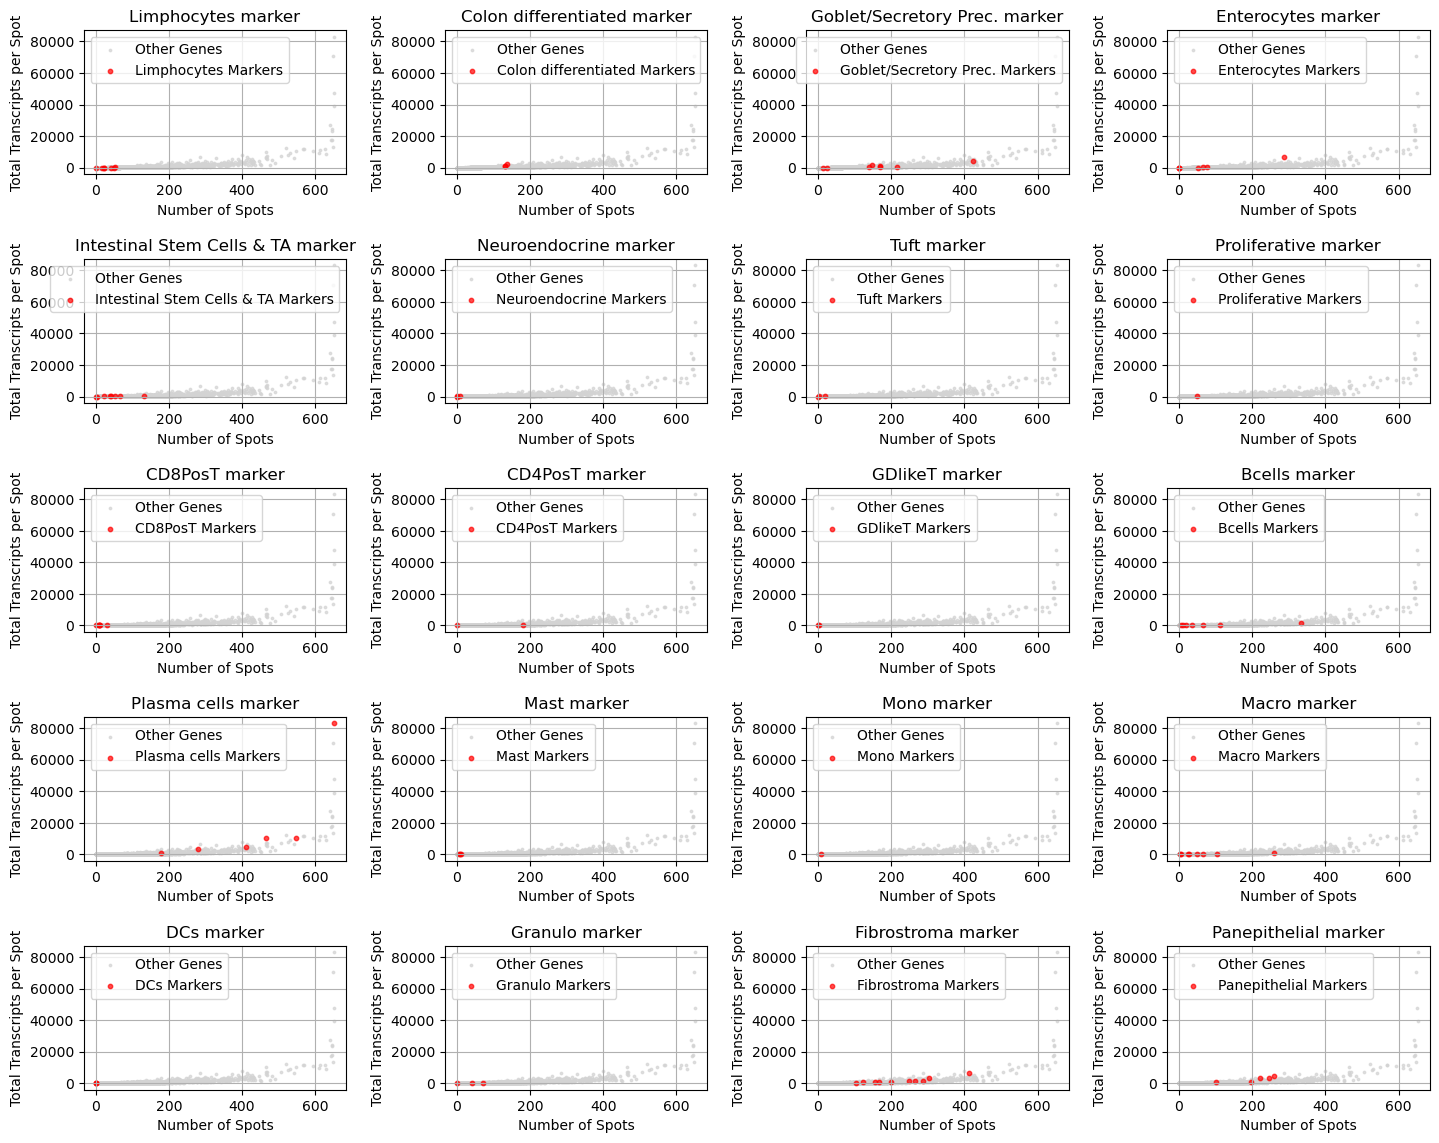

In [19]:
import matplotlib.pyplot as plt

total_counts_per_gene = f_spot_gene.sum(axis=1)

# Create a 5x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 12))
fig.tight_layout(pad=4.0)

# Create masks and marker types (as previously shown)

# List of masks and corresponding marker types
masks = [limpho_mask, colon_diff_mask, goblet_sec_mask, entero_mask, isc_mask, neuroendocrine_mask, tuft_mask,
         proliferative_mask, cd8post_mask, cd4post_mask, gdlike_mask, bcells_mask, plasma_cells_mask, mast_mask,
         mono_mask, macro_mask, dcs_mask, granulo_mask, fibrostroma_mask, panepithelial_mask]

cell_types = ['Limphocytes','Colon differentiated', 'Goblet/Secretory Prec.', 'Enterocytes', 'Intestinal Stem Cells & TA', 'Neuroendocrine', 'Tuft', 'Proliferative', 'CD8PosT', 'CD4PosT', 'GDlikeT', 'Bcells', 'Plasma cells', 'Mast', 'Mono', 'Macro', 'DCs', 'Granulo', 'Fibrostroma', 'Panepithelial']

# Iterate over masks and corresponding colors
for i, (mask, cell) in enumerate(zip(masks, cell_types)):
    row = i // 4
    col = i % 4

    # Scatter plot for each marker type
    axes[row, col].scatter(samples_containing_gene[~mask], total_counts_per_gene[~mask], color='lightgrey', alpha=0.7, s=3, label='Other Genes')
    axes[row, col].scatter(samples_containing_gene[mask], total_counts_per_gene[mask], color='red', alpha=0.7, s=10, label=f'{cell} Markers')
    axes[row, col].set_xlabel('Number of Spots')
    axes[row, col].set_ylabel('Total Transcripts per Spot')
    axes[row, col].set_title(f'{cell} marker')
    axes[row, col].legend()
    axes[row, col].grid(True)

# Show the plot
plt.show()

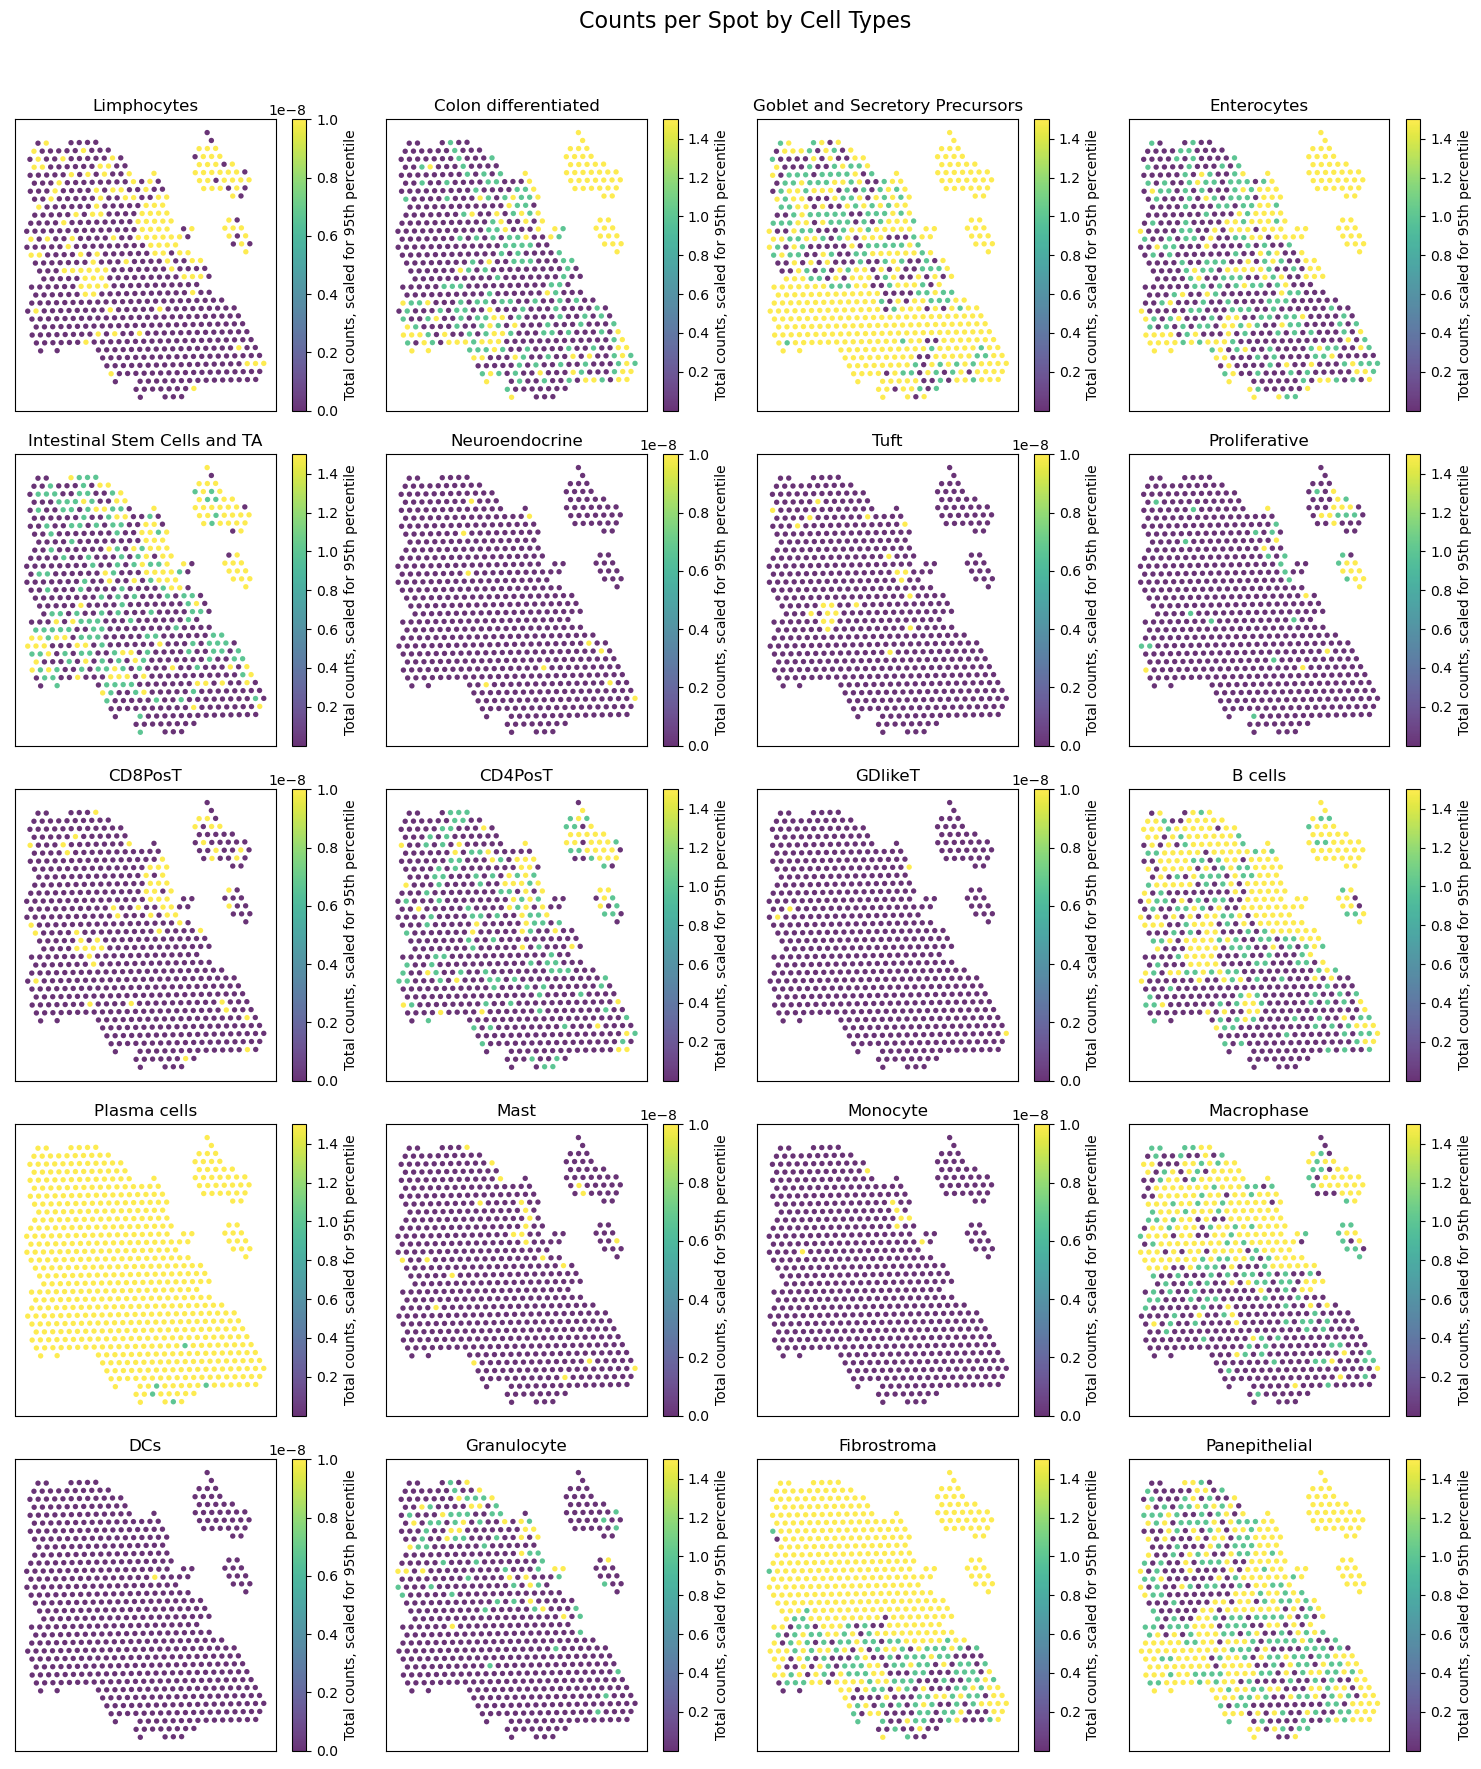

In [20]:
### Spatial heatmaps by cell types:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Define the cell types and corresponding subset names
cell_types = ['Limphocytes', 'Colon differentiated', 'Goblet and Secretory Precursors', 'Enterocytes', 'Intestinal Stem Cells and TA', 
              'Neuroendocrine', 'Tuft', 'Proliferative', 'CD8PosT', 'CD4PosT', 'GDlikeT', 'B cells', 'Plasma cells', 'Mast', 
              'Monocyte', 'Macrophase', 'DCs', 'Granulocyte', 'Fibrostroma', 'Panepithelial']

subset_names = ['limpho_subset', 'colon_diff_subset', 'goblet_sec_subset', 'entero_subset', 'isc_subset',
                'neuroendocrine_subset', 'tuft_subset', 'proliferative_subset', 'cd8post_subset', 'cd4post_subset',
                'gdlike_subset', 'bcells_subset', 'plasma_cells_subset', 'mast_subset', 'mono_subset', 'macro_subset',
                'dcs_subset', 'granulo_subset', 'fibrostroma_subset', 'panepithelial_subset']

# Create a 4x5 grid for the scatter plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 18))
fig.suptitle('Counts per Spot by Cell Types', fontsize=16)

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()
minnn=0.00000001

# Iterate over each cell type and corresponding subset name, and create a scatter plot
for i, (cell_type, subset_name) in enumerate(zip(cell_types, subset_names)):
    # Get the subset corresponding to the current cell type
    cell_subset = eval(subset_name)
    
    # Calculate total counts per spot for the current cell type
    cell_counts_per_spot = np.sum(cell_subset, axis=0)

    mask_95 = cell_subset.to_numpy() < np.quantile(cell_subset.to_numpy(), 0.95)
    mask_95_max = mask_95.max()
    mask_95_max = mask_95_max + 0.5*(mask_95_max)
    
    # Create scatter plot
    sp= axes[i].scatter(w / 2, z, c=cell_counts_per_spot, cmap='viridis', alpha=0.8, s=15, edgecolors='none',vmax=mask_95_max,vmin=minnn)
    axes[i].set_title(f'{cell_type}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].invert_yaxis()
    fig.colorbar(sp, ax=axes[i],label='Total counts, scaled for 95th percentile')


# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Outliers

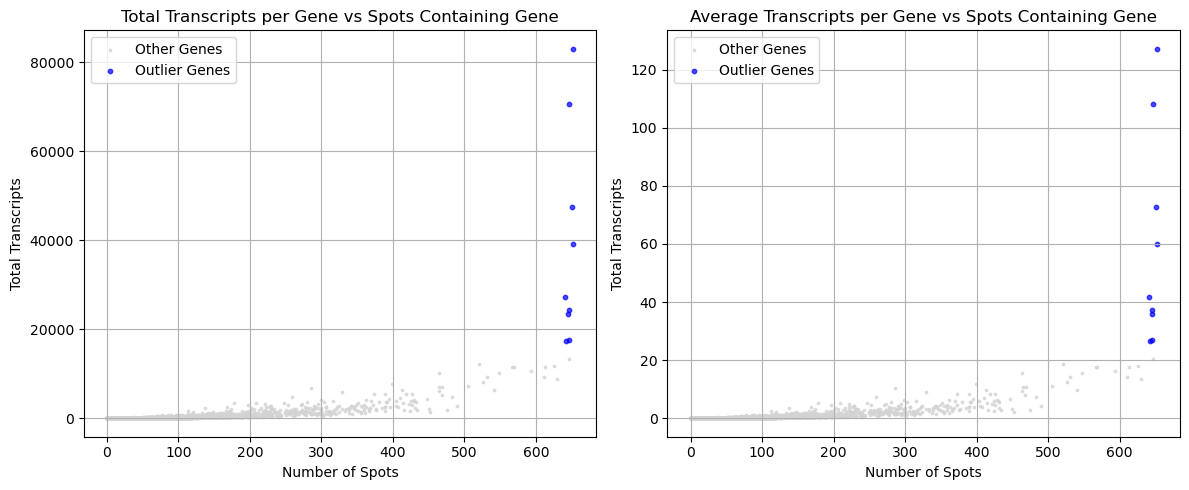

In [21]:
### plot outliers on scatterplot
import numpy as np
from scipy.stats import zscore

total_counts_per_gene = f_spot_gene.sum(axis=1)
samples_containing_gene = (f_spot_gene > 0).sum(axis=1)

# Calculate Z-scores for both variables
z_scores_samples = zscore(samples_containing_gene)
z_scores_counts = zscore(total_counts_per_gene)

# Set a threshold for identifying outliers (can adjust this threshold)
z_score_threshold = 20

# Identify outliers based on the threshold
outliers_mask = np.logical_or(np.abs(z_scores_samples) > z_score_threshold, np.abs(z_scores_counts) > z_score_threshold)

# Get the gene names corresponding to the outliers
outlier_gene_names = f_spot_gene.index[outliers_mask]
outlier_mask = f_spot_gene.index.isin(outlier_gene_names)

# Create subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot for Total Transcripts
axes[0].scatter(samples_containing_gene[~outlier_mask], total_counts_per_gene[~outlier_mask], color='lightgrey', alpha=0.7, s=3, label='Other Genes')
axes[0].scatter(samples_containing_gene[outlier_mask], total_counts_per_gene[outlier_mask], color='blue', alpha=0.7, s=10, label='Outlier Genes')
axes[0].set_xlabel('Number of Spots')
axes[0].set_ylabel('Total Transcripts')
axes[0].set_title('Total Transcripts per Gene vs Spots Containing Gene')
axes[0].legend()
axes[0].grid(True)

# Scatter plot for Average Transcripts
axes[1].scatter(samples_containing_gene[~outlier_mask], av_counts_per_gene[~outlier_mask], color='lightgrey', alpha=0.7, s=3, label='Other Genes')
axes[1].scatter(samples_containing_gene[outlier_mask], av_counts_per_gene[outlier_mask], color='blue', alpha=0.7, s=10, label='Outlier Genes')
axes[1].set_xlabel('Number of Spots')
axes[1].set_ylabel('Total Transcripts')
axes[1].set_title('Average Transcripts per Gene vs Spots Containing Gene')
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

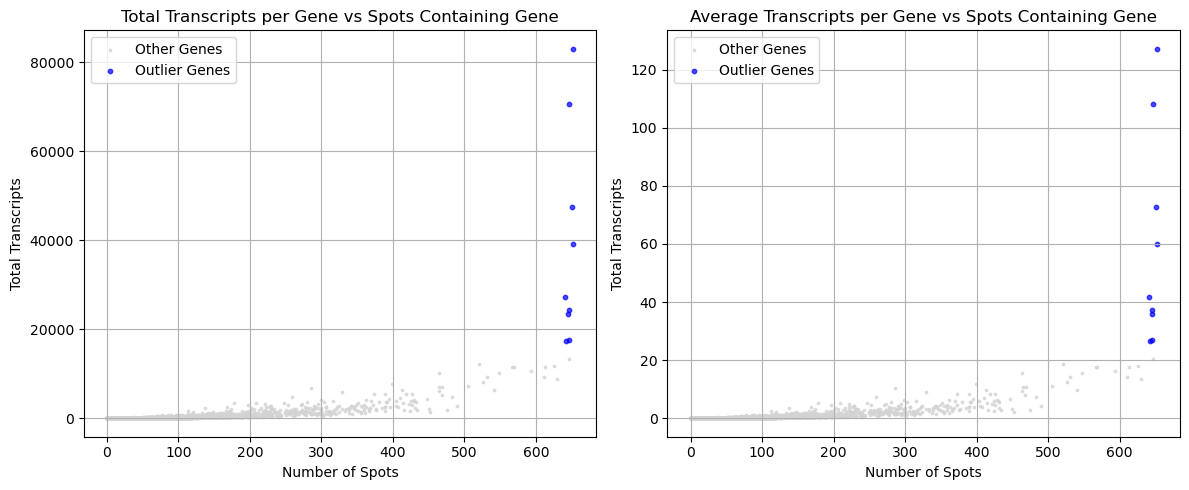

In [22]:
# Plot them for sanity check 
# Create subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot for Total Transcripts
axes[0].scatter(samples_containing_gene[~outlier_mask], total_counts_per_gene[~outlier_mask], color='lightgrey', alpha=0.7, s=3, label='Other Genes')
axes[0].scatter(samples_containing_gene[outlier_mask], total_counts_per_gene[outlier_mask], color='blue', alpha=0.7, s=10, label='Outlier Genes')
axes[0].set_xlabel('Number of Spots')
axes[0].set_ylabel('Total Transcripts')
axes[0].set_title('Total Transcripts per Gene vs Spots Containing Gene')
axes[0].legend()
axes[0].grid(True)

# Scatter plot for Average Transcripts
axes[1].scatter(samples_containing_gene[~outlier_mask], av_counts_per_gene[~outlier_mask], color='lightgrey', alpha=0.7, s=3, label='Other Genes')
axes[1].scatter(samples_containing_gene[outlier_mask], av_counts_per_gene[outlier_mask], color='blue', alpha=0.7, s=10, label='Outlier Genes')
axes[1].set_xlabel('Number of Spots')
axes[1].set_ylabel('Total Transcripts')
axes[1].set_title('Average Transcripts per Gene vs Spots Containing Gene')
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

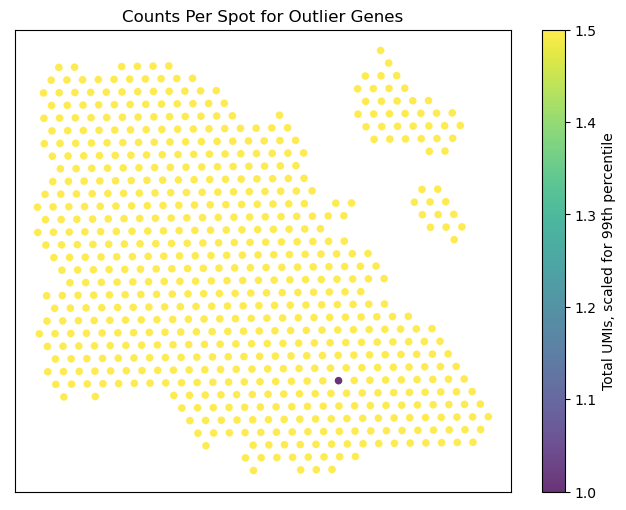

In [23]:
### plot outliers spatially
import math
outlier_df = f_spot_gene[f_spot_gene.index.isin(outlier_gene_names)]
outlier_counts_per_spot = np.sum(outlier_df, axis=0)

# color = np.emath.logn(1.8, outlier_counts_per_spot)
# color = [0 if c < 0 else c for c in color ]

#outlier_genes_per_spot = np.sum(f_matrix_array > 0, axis=0)

e=0.0000000000000001

out_95 = outlier_df.to_numpy() < np.quantile(outlier_df.to_numpy(), 0.99)
out_95_max = out_95.max()
out_95_max = out_95_max + 0.5*(out_95_max)

# Create hm with color scale determined by values: counts/spot, filt
plt.figure(figsize=(8, 6))
plt.scatter(w / 2, z, c= outlier_counts_per_spot, cmap='viridis', alpha=0.8, s =30, edgecolors='none',vmax=out_95_max)
plt.colorbar(label='Total UMIs, scaled for 99th percentile') # Add color bar with label
plt.title('Counts Per Spot for Outlier Genes')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()